In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from collections import Counter
import heapq
from operator import itemgetter
from multiprocessing import Pool
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Flatten
from tensorflow.keras.regularizers import l1_l2
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt


/var/folders/sd/j5p08m515kd7n9549lkkz_q40000gn/T/ipykernel_65933/683333017.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [2]:
# Load dataset

df = pd.read_csv("./dataset/news.csv")

In [3]:
df = df.head(1000)

og_shape = df.shape

In [4]:
df = df.drop(columns=['Unnamed: 0', 'title'])

In [5]:
label_map = {'REAL': 0, 'FAKE': 1}
df['label'] = df['label'].map(label_map)


In [6]:
size_mini = 1000

df = df.loc[df['text'].str.len() > size_mini]

print("We have kept", (df.shape[0]/og_shape[0])*100, "% of the data")


We have kept 85.0 % of the data


In [7]:
def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_numbers(x):
    digit_map = {
        '0': 'zero',
        '1': 'one',
        '2': 'two',
        '3': 'three',
        '4': 'four',
        '5': 'five',
        '6': 'six',
        '7': 'seven',
        '8': 'eight',
        '9': 'nine'
    }
    
    x = re.sub('[0-9]{7,}', 'millions', x)
    x = re.sub('[0-9]{4,6}', 'thousand', x)
    x = re.sub('[0-9]{3}', 'hundred', x)
    x = re.sub('[0-9]{2}', 'tens', x)
    x = re.sub('[0-9]{1}', 'tens', x)
    x = re.sub(r'\b\d\b', lambda match: digit_map[match.group()], x)

    return x
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)


df['text'] = df["text"].apply(clean_text)
df['text'] = df["text"].apply(clean_numbers)
df['text'] = df["text"].apply(replace_contractions)


In [8]:
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

# Determine the 95th percentile of these lengths
sequence_length_95 = np.percentile(df['text_length'], 95)

sequence_length = int(np.ceil(sequence_length_95))

print(f"Length covering at least 95% of the news: {sequence_length}")
df = df.drop(columns=["text_length"])
print("The kept sequence is: ", sequence_length, " words")


Length covering at least 95% of the news: 2248
The kept sequence is:  2248  words


In [9]:
max_features = 10000

vectorization = TextVectorization(standardize="lower_and_strip_punctuation", 
                                  max_tokens=max_features, 
                                  output_mode='int', 
                                  output_sequence_length=sequence_length)
vectorization.adapt(df["text"])

words_database = vectorization.get_vocabulary()
database_index = {word: index for index, word in enumerate(words_database)}


Utilize Glove Twitter Embedding


In [10]:
def load_glove_index():
    EMBEDDING_FILE = 'glove.twitter.27B.200d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, 'r', encoding='utf-8'))
    return embeddings_index

glove_embedding_index_twitter = load_glove_index()

In [11]:
import numpy as np
from tqdm import tqdm

def create_glove(word_index, embeddings_index):
    all_embs = list(embeddings_index.values())  # Convert values to list
    embed_size = all_embs[0].shape[0]  # Assuming all embeddings have the same size
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(0, 1, (nb_words, embed_size))

    count_found = nb_words
    for word, i in tqdm(word_index.items()):
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] =  embedding_vector
        else:
            if word.islower():
                embedding_vector = embeddings_index.get(word.capitalize())
                if embedding_vector is not None: 
                    embedding_matrix[i] = embedding_vector
                else:
                    count_found -= 1
            else:
                count_found -= 1
    print("We found", count_found, "words")
    return embedding_matrix


In [12]:
adapted_glove_twitter = create_glove(database_index, glove_embedding_index_twitter)

embedding_dim = 200
embedding_layer = Embedding(input_dim=max_features, output_dim=embedding_dim, weights=[adapted_glove_twitter], input_length=sequence_length, trainable=False)


100%|██████████| 10000/10000 [00:00<00:00, 174416.01it/s]

We found 9233 words



/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [13]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras.layers import Embedding, Dropout, Layer

# Taken from https://github.com/eclarson/MachineLearningNotebooks/blob/master/13a.%20Sequence%20Basics%20%5Bexperimental%5D.ipynb

# The transformer architecture 
class TransformerBlock(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # setup the model heads and feedforward network
        self.att = MultiHeadAttention(num_heads=num_heads, 
                                      key_dim=embed_dim)
        
        # make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add(Dense(ff_dim, activation='relu') )
        self.ffn.add(Dense(embed_dim) )
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=True):
        # apply the layers as needed (similar to PyTorch)
        
        # get the attention output from multi heads
        # Using same inpout here is self-attention
        # call inputs are (query, value, key) 
        # if only two inputs given, value and key are assumed the same
        attn_output = self.att(inputs, inputs)
        
        # create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output)
        
        # apply dropout if training
        out1 = self.dropout1(out1, training=training)
        
        # place through feed forward after layer norm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        
        # apply dropout if training
        out2 = self.dropout2(out2, training=training)
        #return the residual from Dense layer
        return out2
    
    
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        # create two embeddings 
        # one for processing the tokens (words)
        self.token_emb = Embedding(input_dim=vocab_size, 
                                   output_dim=embed_dim)
        # another embedding for processing the position
        self.pos_emb = Embedding(input_dim=maxlen, 
                                 output_dim=embed_dim)

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [58]:
def transformer_model():
    embed_dim = embedding_dim  # Assuming you are using GloVe embeddings with dimension 200
    num_heads = 1
    ff_dim = 32

    inputs = tf.keras.Input(shape=(sequence_length,), dtype=tf.int32)  # Use dtype=tf.string for token sequences
    x = inputs
    x = TokenAndPositionEmbedding(sequence_length, max_features, embed_dim)(x)
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(20, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = transformer_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [59]:
model.summary()


Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_38 (InputLayer)     │ (None, 2248)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_19 │ (None, 2248, 200)      │     2,449,600 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_19            │ (None, 2248, 200)      │       174,632 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_19     │ (None, 200)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 20)             │         4,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,628,273 (10.03 MB)

 Trainable params: 2,628,273 (10.03 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# from tensorflow.keras.layers import TextVectorization
train_df, test_df = train_test_split(df, test_size=0.2, random_state=10)

# history = model.fit(train_df['text'], train_df['label'], epochs=20, validation_data=(test_df['text'], test_df['label']))

train_sequences = vectorization(train_df['text'])
test_sequences = vectorization(test_df['text'])
history = model.fit(train_sequences, train_df['label'], epochs=15, validation_data=(test_sequences, test_df['label']))


Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.5256 - loss: 0.6912 - val_accuracy: 0.4941 - val_loss: 0.6986
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5590 - loss: 0.6896 - val_accuracy: 0.5000 - val_loss: 0.7008
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5324 - loss: 0.6814 - val_accuracy: 0.5353 - val_loss: 0.6908
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.5892 - loss: 0.6854 - val_accuracy: 0.5000 - val_loss: 0.7094
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.5326 - loss: 0.6812 - val_accuracy: 0.5118 - val_loss: 0.6892
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5306 - loss: 0.6626 - val_accuracy: 0.5118 - val_loss: 0.7340
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.6405 - loss: 0.6210 - val_accuracy: 0.6353 - val_loss: 0.6893
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.7661 - loss: 0.4529 - val_accuracy: 0.8765 - val_loss:

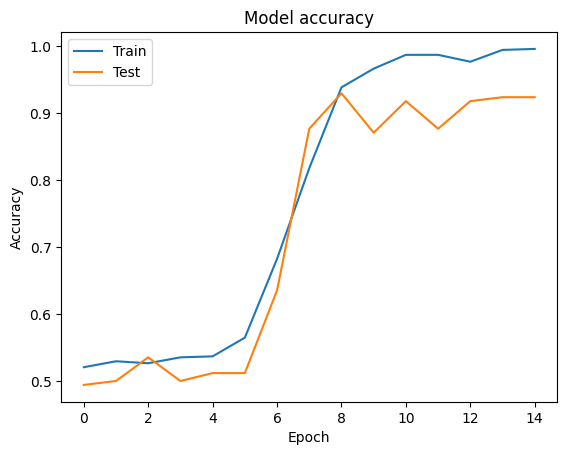

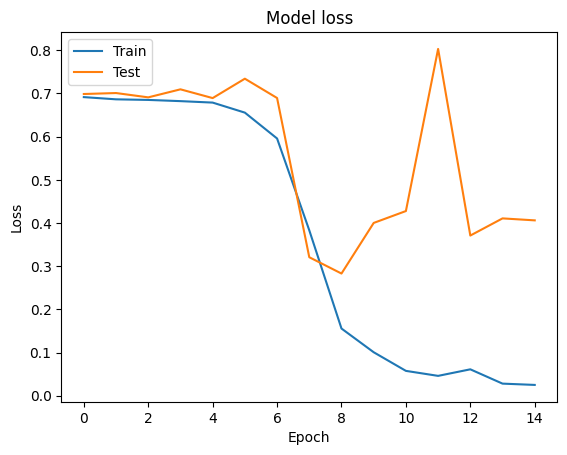

In [63]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [65]:
predictions = model.predict(test_sequences)

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 703ms/step


<Axes: >

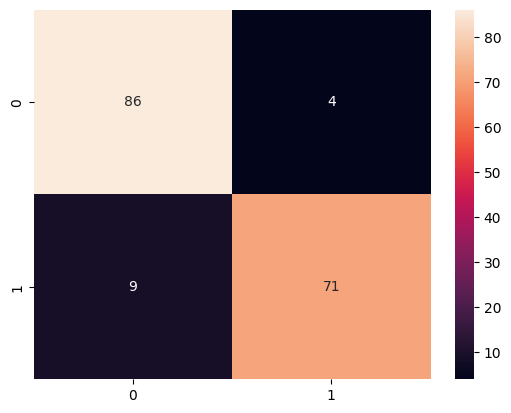

In [66]:
predicted_labels = (predictions > 0.5).astype(int)
conf_matrix = confusion_matrix(test_df['label'], predicted_labels)

sns.heatmap(conf_matrix, annot=True)


In [67]:
print(classification_report(test_df['label'], predicted_labels, target_names=['True', 'Fake']))


              precision    recall  f1-score   support

        True       0.91      0.96      0.93        90
        Fake       0.95      0.89      0.92        80

    accuracy                           0.92       170
   macro avg       0.93      0.92      0.92       170
weighted avg       0.92      0.92      0.92       170

